# Time Series Analysis: ARIMA and Inventory Planning

![Walmart logo](https://imgur.com/SxSjgvk.png)

## Walmart Recruiting - Store Sales Forecasting

Retrieved from [Kaggle](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data)

> You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

> In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

### Importing Necessary Libraries & Loading Data

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))#to expand the size of my container so it can take fill up my entire monitor

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## EDA

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of our data. For every set of data this means something different. But the bare minimum is understanding what types of data we have, knowing if there are missing values and checking to be sure that our date column (or index) is in a proper date format.

Accordingly we should also check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3+ MB


In [5]:
data.index = pd.to_datetime(data.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

In [6]:
data['Store'].head()

Date
2010-02-05    1
2010-02-12    1
2010-02-19    1
2010-02-26    1
2010-03-05    1
Name: Store, dtype: int64

In [10]:
#isolate store one
store_1 = data['Store'] == 1
data = data[store_1]

#creating a weekly sales df with store_1
Weekly_Sales = pd.DataFrame(data['Weekly_Sales'].groupby(store_1.index).sum())

Weekly_Sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


#### 2. Plotting & Interpreting Time Series

**First, we'll Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

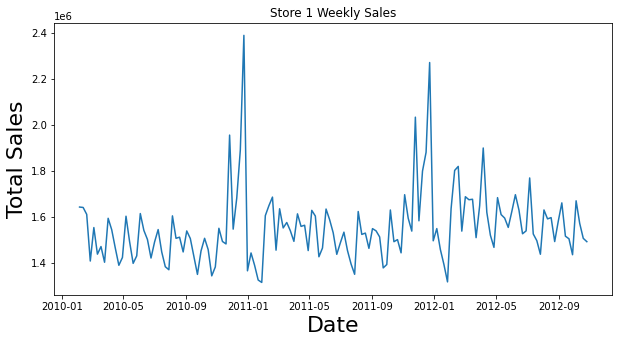

In [11]:
# plot
plt.figure(figsize=(10,5))
plt.plot(Weekly_Sales)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Total Sales', fontsize=22)
plt.title('Store 1 Weekly Sales');

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

**Let's calculate some rolling means for `Weekly_Sales` and then plot them on a single set of axes.**

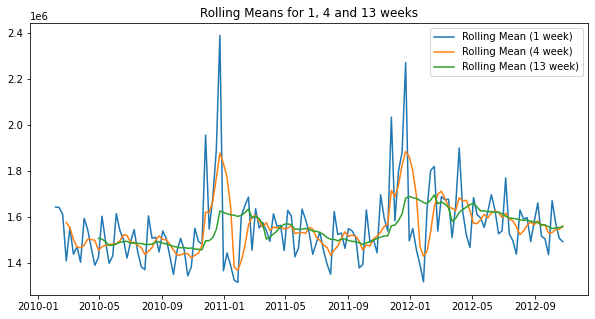

In [12]:
# Set a rolling mean with windows of 1, 4, and 13.
rol1ing_1  = Weekly_Sales.rolling(window = 1).mean()
rolling_4  = Weekly_Sales.rolling(window = 4).mean()
rolling_13 = Weekly_Sales.rolling(window = 13).mean()

# Plot
plt.figure(figsize=(10,5))
plt.plot(rol1ing_1, label='Rolling Mean (1 week)')
plt.plot(rolling_4, label='Rolling Mean (4 week)')
plt.plot(rolling_13, label='Rolling Mean (13 week)')

plt.legend(loc='best')

plt.title('Rolling Means for 1, 4 and 13 weeks')
plt.show();

**Noticeable trends:**
- Huge peaks around the holidays followed by huge drops post-holidays.
- Total sales seems to be trending upwards for non-holiday periods.

#### 3. Autocorrelations

Autocorrelation: the influence a serial observation has on the observations which follow.

Let's calculate autocorrelation in our `Weekly_Sales` to see how it differs as lag-weeks vary.

In [13]:
print(f'1 week lag: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=1),4)}')
print(f'2 week lag: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=2),4)}')
print(f'1 year lag: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=52),4)}')

1 week lag: 0.3022
2 week lag: 0.1274
1 year lag: 0.8954


**What do we notice about the series based on these autocorrelations?**

Answer:
- There's an incredibly high correlation between year-on-year weekly sales.
- There's a decent correlation between week-on-week sales.
- There's a surprisingly (to me) weakish correlation between weekly sales with a two week lag. 

**3c. Plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data**

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

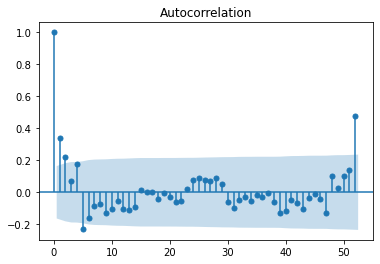

In [11]:
plot_acf(Weekly_Sales, lags=52);

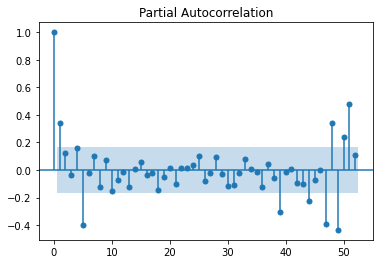

In [12]:
plot_pacf(Weekly_Sales, lags=52);

#### 4. Interpreting the `ACF` and `PACF` Plots

**What do the ACF and PACF graphs tell us about your sales data?**

The blue band represents a 95% confidence interval. If the value of the ACF or PACF goes outside the blue band, that means that correlation is statistically significant.

Hence:
- At lag = 1, there is some relationship between the sales and prior day sales evidenced by both the ACF and PACF.
- At lag = 4, there seems to be a correlation in both the ACF and PACF, this might be due to a monthly sales promotion or some kind of monthly cycle in sales.
- At lag = 5 there is an interesting negative relationship which we cannot immediately infer about in the PACF (direct with no in-between relationships).
- At lag = 48, 50, 51, and 52 there is significant positive relationship in the PACF, possibly a correlation to monthly sales, within the seasonality of a year.
- At lag = 52, there is a clear correlation in both the ACF and PACF. This should give us a sense that there might be a seasonal component in the series.

**The `ACF` and `PACF` will help us to determine the number of autoregressive terms in our model and the number of previous errors to incorporate.**

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. We need to use the first *75%* of observations as training data and the following 25% for test data.

In [14]:
Weekly_Sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [15]:
from sklearn.model_selection import train_test_split

In [70]:
train, test = train_test_split(Weekly_Sales, test_size = 0.25, shuffle = False) # Shuffle = False is IMPORTANT!

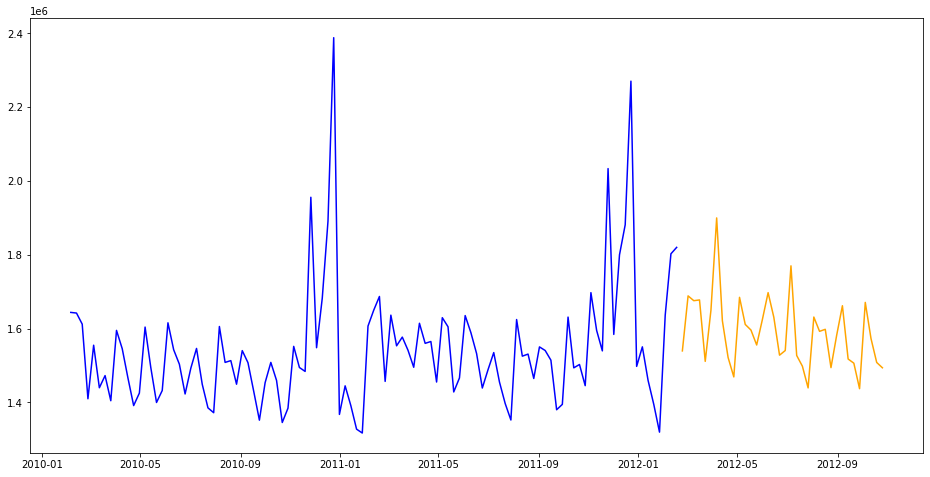

In [72]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='blue')
    plt.plot(test, c='orange');

train_test_plot(train, test)

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first.

**6a. Instantiate and fit an `arima_1_0_0` model.**

In [73]:
arima_1_0_0 = model.fit()

In [74]:
start = test.index[0]
end = test.index[-1]

In [84]:
train_start = train.index[0]
train_end = train.index[-1]

In [85]:
train_start

Timestamp('2010-02-05 00:00:00')

In [86]:
train_end

Timestamp('2012-02-17 00:00:00')

In [75]:
start

Timestamp('2012-02-24 00:00:00')

In [76]:
end

Timestamp('2012-10-26 00:00:00')

In [77]:
from datetime import datetime

In [78]:
preds = model.predict(params=arima_1_0_0.params,
                      start=datetime(2012,2,24),
                      end=datetime(2012,10,26))

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [48]:
import statsmodels

from sklearn.metrics import mean_squared_error

round(mean_squared_error(pd.DataFrame(test), preds),2)

11108594617.02

**6c. How effective do you think this `AR(1)` model is?**

In [50]:
error = round(mean_squared_error(pd.DataFrame(test), preds),2)

In [51]:
# Look at min and max sales, as well as how our MSE compares to them.
print(f'Minimum Sales: {round(Weekly_Sales["Weekly_Sales"].min(),2)}')
print(f'Maximum Sales: {round(Weekly_Sales["Weekly_Sales"].max(),2)}')
print(f'MSE relative to minimum values in series: {round(error / Weekly_Sales["Weekly_Sales"].min(),2)}.')
print(f'MSE relative to maximum values in series: {round(error / Weekly_Sales["Weekly_Sales"].max(),2)}.')

Minimum Sales: 1316899.31
Maximum Sales: 2387950.2
MSE relative to minimum values in series: 8435.42.
MSE relative to maximum values in series: 4651.94.


Looking at the ratio of the *mean* error to the minimum and maximum values in the series, our model does not seem terrible. 

However, as we'll see shortly, when you look at the decay in the predictions based on the graph, it is clear that earlier predictions have less erroneous than later predictions, so improvement is probably necessary to use this model as is.

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. That being said, it doesn't tell the whole story. 

Is our model off by a lot in one specific window of time? 

Is our model only slightly off, but over all time? 

It might be helpful to plot residuals to see when our model is off most.

**7a. Let's calculate and and plot the residuals of our `AR(1)` model.**

In [25]:
date_list =  pd.date_range(start, periods=36, freq ='W')
preds = pd.DataFrame(preds, index=date_list, columns = ['Weekly Sales'])
preds.head()

,Weekly Sales
2012-02-26,4.824138e+07
2012-03-04,4.756934e+07
2012-03-11,4.733841e+07
2012-03-18,4.725905e+07
2012-03-25,4.723178e+07


In [26]:
test['Weekly_Sales'].shape

(36,)

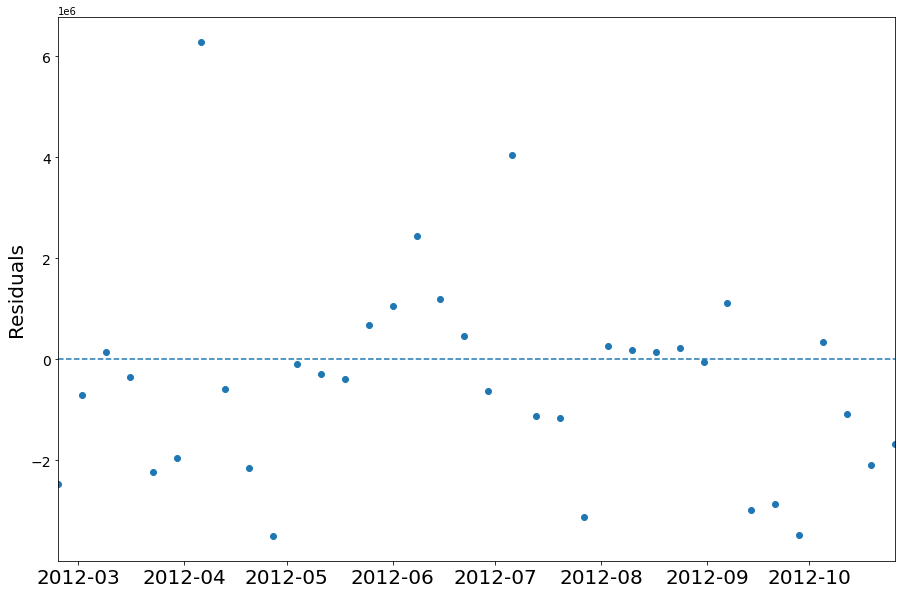

In [27]:
plt.figure(figsize=(15,10))

residuals = test['Weekly_Sales'].values - preds['Weekly Sales'].values

plt.scatter(test['Weekly_Sales'].index, residuals)

plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

As we can see, there are some days where the prediction is off more than others. 

This could be specific to those days, or it could be a limit of the model. 

It looks like early time periods are predicting too low (residuals = true - predicted values are high) and later time periods are predicting closer to accurate (residuals centered around 0).

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

In [95]:
model_2 = ARIMA(endog = train.astype(float).dropna(), # endog = Y variable
              order = (2, 0, 0)) 
arima_2_0_0 = model_2.fit()

preds_2 = model_2.predict(params=arima_2_0_0.params,
                      start=datetime(2012,2,24),
                      end=datetime(2012,10,26))
preds_2_training = model_2.predict(params=arima_2_0_0.params,
                      start=datetime(2010,2,5),
                      end=datetime(2012,2,17))

print(f'Training MSE: {round(mean_squared_error(pd.DataFrame(train), preds_2_training),2)}')
print(f'Testing MSE: {round(mean_squared_error(pd.DataFrame(test), preds_2),2)}')

Training MSE: 25814330992.09
Testing MSE: 10932676904.59


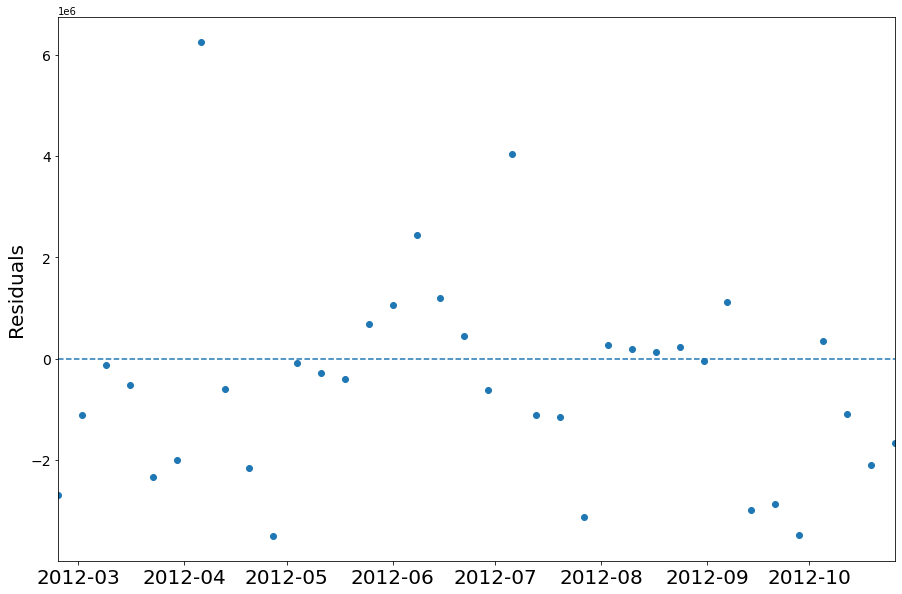

In [31]:
# Set figure size.
plt.figure(figsize=(15,10))

# Calculate residuals.
residuals = test['Weekly_Sales'].values - preds_2['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, residuals)

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

**8b. Let's fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** 

(_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

In [98]:
model = ARIMA(endog = train.astype(float).dropna(), # endog = Y variable
              order = (2, 0, 2)) 
arima_2_0_2 = model.fit()

preds_3 = model.predict(params=arima_2_0_2.params,
                      start=datetime(2012,2,24),
                      end=datetime(2012,10,26))

preds_3_training = model_2.predict(params=arima_2_0_0.params,
                      start=datetime(2010,2,5),
                      end=datetime(2012,2,17))

print(f'Training MSE: {round(mean_squared_error(pd.DataFrame(train), preds_3_training),2)}')
print(f'Testing MSE: {round(mean_squared_error(pd.DataFrame(test), preds_3),2)}')

Training MSE: 25814330992.09
Testing MSE: 11042488911.07


#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Let's use an Augmented Dickey-Fuller test to estimate whether or not our data are stationary.**

In [99]:
from statsmodels.tsa.stattools import adfuller

In [100]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [101]:
interpret_dftest(adfuller(train['Weekly_Sales']))

Test Statistic   -4.688682
p-value           0.000088
dtype: float64

**Because  $p \approx 0.000011$ , it is smaller than any  𝛼  we'd reasonably pick. Thus, we can accept that our series is stationary.**

This means we can fit an ARIMA model to this data without differencing.

#### 10. Differenced Data

**10a. We'll ceate new columns in our `Weekly_Sales` dataframe.**

In [37]:
Weekly_Sales['first_diff_sales'] = Weekly_Sales['Weekly_Sales'].diff(1)
Weekly_Sales['second_diff_sales'] = Weekly_Sales['Weekly_Sales'].diff(2)
Weekly_Sales['third_diff_sales'] = Weekly_Sales['Weekly_Sales'].diff(3)
Weekly_Sales['fourth_diff_sales'] = Weekly_Sales['Weekly_Sales'].diff(4)
Weekly_Sales.head()

,Weekly_Sales,first_diff_sales,second_diff_sales,third_diff_sales,fourth_diff_sales
Date,,,,,
2010-02-05,49750740.50,NaN,NaN,NaN,NaN
2010-02-12,48336677.63,-1414062.87,NaN,NaN,NaN
2010-02-19,48276993.78,-59683.85,-1473746.72,NaN,NaN
2010-02-26,43968571.13,-4308422.65,-4368106.50,-5782169.37,NaN
2010-03-05,46871470.30,2902899.17,-1405523.48,-1465207.33,-2879270.2


**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [38]:
interpret_dftest(adfuller(Weekly_Sales['first_diff_sales'].dropna()))

Test Statistic   -6.699469e+00
p-value           3.922579e-09
dtype: float64

In [39]:
interpret_dftest(adfuller(Weekly_Sales['second_diff_sales'].dropna()))

Test Statistic   -7.276766e+00
p-value           1.537185e-10
dtype: float64

In [40]:
interpret_dftest(adfuller(Weekly_Sales['third_diff_sales'].dropna()))

Test Statistic   -5.123502
p-value           0.000013
dtype: float64

In [41]:
interpret_dftest(adfuller(Weekly_Sales['fourth_diff_sales'].dropna()))

Test Statistic   -5.529177
p-value           0.000002
dtype: float64

The data appear to be stationary in all cases. Since the smallest differencing needed is $d = 0$, we probably wouldn't do any differencing.

**Given that the data seems more stationary, it might make sense to try an ARIMA with a differenced value. It may or may not improve the model, but let's try it!**

#### 11.  ARIMA MODEL

In [105]:
model = ARIMA(endog = train.astype(float).dropna(), # endog = Y variable
              order = (2, 2, 2)) # 

arima_2_3_2 = model.fit()

In [106]:
preds_4 = model.predict(params=arima_2_3_2.params,
                      start=datetime(2012,2,24),
                      end=datetime(2012,10,26))

In [107]:
round(mean_squared_error(pd.DataFrame(test), preds_4),2)

2530984071434.2

Our results aren't great!

The MSE has balloned. 

#### 12.  SARIMAX Model

Let's build a SARIMAX model to look at seasonal effects on our data!

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [46]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for S in range(48, 54, 4):
    for D in range(3):
        for P in range(3):
            for Q in range(3):
                try:
                    print(f'Attempting to fit SARIMAX(2,0,2)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = train['Weekly_Sales'].dropna(),
                                      order = (2, 0, 2),
                                      seasonal_order = (P, D, Q, S))
 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=datetime(2012,2,24),
                                          end=datetime(2012,10,26))

                    # Evaluate predictions.
                    print(f'The MSE for (2, 0, 2)x({P},{D},{Q},{S}) is: {mean_squared_error(pd.DataFrame(test), preds)}')

                    # Save for final report.
                    if mean_squared_error(pd.DataFrame(test), preds) <= best_mse:
                        best_mse = mean_squared_error(pd.DataFrame(test), preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(2, 0, 2)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

Attempting to fit SARIMAX(2,0,2)x(0,0,0,48)
The MSE for (2, 0, 2)x(0,0,0,48) is: 4030454342326.3926
Attempting to fit SARIMAX(2,0,2)x(0,0,1,48)
The MSE for (2, 0, 2)x(0,0,1,48) is: 4197793284641.9263
Attempting to fit SARIMAX(2,0,2)x(0,0,2,48)
The MSE for (2, 0, 2)x(0,0,2,48) is: 6548499986550.199
Attempting to fit SARIMAX(2,0,2)x(1,0,0,48)
The MSE for (2, 0, 2)x(1,0,0,48) is: 4675267611756.798
Attempting to fit SARIMAX(2,0,2)x(1,0,1,48)
The MSE for (2, 0, 2)x(1,0,1,48) is: 6668006643082.118
Attempting to fit SARIMAX(2,0,2)x(1,0,2,48)
The MSE for (2, 0, 2)x(1,0,2,48) is: 6471536843110.636
Attempting to fit SARIMAX(2,0,2)x(2,0,0,48)
The MSE for (2, 0, 2)x(2,0,0,48) is: 6819017039149.47
Attempting to fit SARIMAX(2,0,2)x(2,0,1,48)
The MSE for (2, 0, 2)x(2,0,1,48) is: 6465265148124.08
Attempting to fit SARIMAX(2,0,2)x(2,0,2,48)
The MSE for (2, 0, 2)x(2,0,2,48) is: 6512718980096.922
Attempting to fit SARIMAX(2,0,2)x(0,1,0,48)
The MSE for (2, 0, 2)x(0,1,0,48) is: 18487897102763.047
Attemptin

### 13. Our Best Model

In [50]:
sarimax = SARIMAX(endog = train['Weekly_Sales'].dropna(),
                 order = (2, 0, 2),
                 seasonal_order = (2, 1, 2, 52))

model = sarimax.fit()

preds = model.predict(start=datetime(2012,2,24),
                      end=datetime(2012,10,26))

2961311316732.919


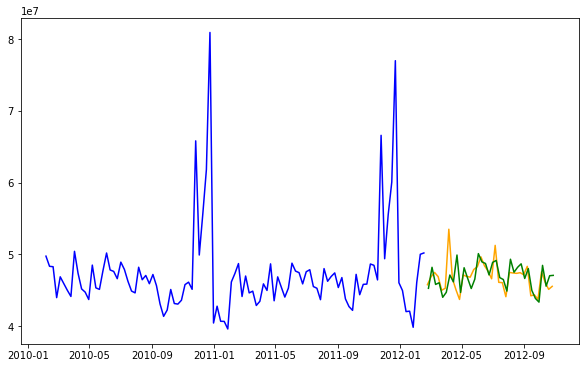

In [51]:
preds = pd.DataFrame(preds.values, index=date_list, columns = ['Weekly Sales'])

# Evaluate predictions.
print(mean_squared_error(pd.DataFrame(test), preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train, color = 'blue')
plt.plot(test, color = 'orange')
plt.plot(preds, color = 'green')
plt.show();

Our model doesn't match the peaks of the true values, and is a bit delayed at times, but it does seem to mirror the cyclical nature of sales a little.

We can improve it though with more data or exogenuous predictors.

### 14. BONUS: Rolling Predictions

**Let's try testing the performance of our model using rolling predictions.**

In [108]:
# Helper function to get first week of month in given date list
def get_first_weeks(date_list):
    firstweeks = []
    for position, date in enumerate(date_list):
        if position > 0:
            if str(date)[5:7] != str(date_list[position-1])[5:7]: firstweeks.append(date)
    return(firstweeks)

The Mean Squared Error is: 10523085647.42388


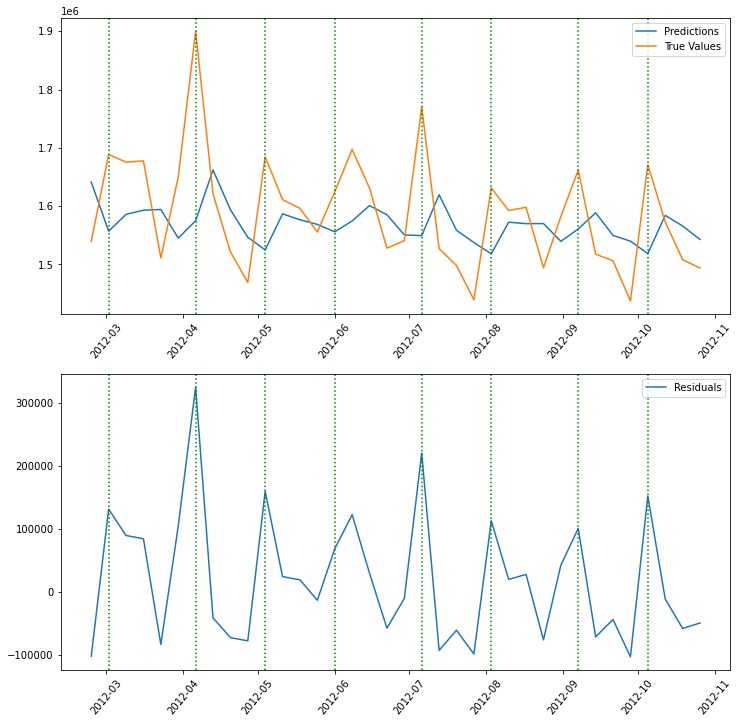

In [109]:
## rolling predictions for AR(2) model 

predictions_rolling = []
training_observations = list(train['Weekly_Sales'].values)
testing_observations = test['Weekly_Sales'].values

for obs in testing_observations:
    model_roll = ARMA(training_observations, (2,0)).fit(disp=0)
    predictions_rolling.append(model_roll.forecast()[0][0])
    training_observations.append(obs)
    
MSE = mean_squared_error(test['Weekly_Sales'], predictions_rolling)
print("The Mean Squared Error is:", MSE)

residuals = test['Weekly_Sales'] - predictions_rolling


fig , (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,12))

ax1.tick_params('x', rotation=50)
ax1.plot(test.index, predictions_rolling, label='Predictions')
ax1.plot(test.index, testing_observations, label='True Values')
for xc in get_first_weeks(list(test.index)):
    ax1.axvline(x=xc, color='g', linestyle=':')
ax1.legend()

ax2.tick_params('x', rotation=50)
ax2.plot(test.index, residuals, label= "Residuals")
for xc in get_first_weeks(list(test.index)):
    ax2.axvline(x=xc, color='g', linestyle=':')
ax2.legend();